In [1]:
# Import necessary libraries. 
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import pygeoinf as inf
from pygeoinf.symmetric_space.sphere import Sobolev
import pyslfp as sl
from pyslfp.operators import SeaLevelOperator, GraceObservationOperator

# Set up the FingerPrint instance
fingerprint = sl.FingerPrint(
    lmax=32,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fingerprint.set_state_from_ice_ng()

# Function for generating random ocean locations.
def random_ocean_locations(n, lat1=-90, lat2=90):
    """
    Returns a set of n points within the oceans. An optional
    range of latitudes can be provided.
    """
    lats = []
    lons = []
    while len(lats) < n:
        lat = np.random.uniform(lat1, lat2)
        lon = np.random.uniform(-180, 180)
        sl = fingerprint.point_evaulation(fingerprint.sea_level, lat, lon)
        if sl > 0:
            lats.append(lat)    
            lons.append(lon)
    return np.array(lats), np.array(lons)

In [2]:
# Set the model space for the ice thickness change. 
order = 2
scale = 0.1
model_space = Sobolev(
    fingerprint.lmax, order, scale, radius=fingerprint.mean_sea_floor_radius
)

# Set the data error measure for the forward ptoblem.
observation_degree = 10
data_space = inf.EuclideanSpace((observation_degree+1)**2 - 4)
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, 0.01)

# Initialise the forward problem.
rotational_feedbacks = False
rtol = 1e-6

sea_level_operator = SeaLevelOperator(
    order,
    scale,
    fingerprint=fingerprint,
    rotational_feedbacks=rotational_feedbacks,
    rtol=1e-6,
)

observation_operator = GraceObservationOperator(
    sea_level_operator, 
    observation_degree
)

gfp = inf.LinearForwardProblem(
    observation_operator.forward_operator,
    data_error_measure
)

# Set a prior distribution.
model_prior_measure = model_space.sobolev_gaussian_measure(2, 0.05, 1)

In [3]:
# Debugging
i = 0
response_space = sea_level_operator.codomain
inc = response_space.subspace_inclusion(i)

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)
single_response = inc(response2[i])

LHS = response_space.inner_product(sea_level_operator(model1), single_response)
RHS = model_space.inner_product(model1, sea_level_operator.adjoint(single_response))
print("Test for the self-adjointness of the sea level operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")
print(f"Difference: {np.abs(LHS - RHS)/np.abs(LHS + RHS)}")

Test for the self-adjointness of the sea level operator:
LHS: 0.3181618746408014
RHS: 0.3181615213203579
Difference: 5.552529511819426e-07


In [4]:
response_space = sea_level_operator.codomain

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)
data2 = gfp.forward_operator(model2)

LHS = response_space.inner_product(sea_level_operator(model1), response2)
RHS = model_space.inner_product(model1, sea_level_operator.adjoint(response2))
print("Test for the self-adjointness of the sea level operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")

print()

LHS = gfp.data_space.inner_product(gfp.forward_operator(model1), data2)
RHS = model_space.inner_product(model1, gfp.forward_operator.adjoint(data2))
print("Test for the self-adjointness of the forward operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")

Test for the self-adjointness of the sea level operator:
LHS: 9632279538052954.0
RHS: 9632279313070146.0

Test for the self-adjointness of the forward operator:
LHS: -1625917030029047.5
RHS: -1625917712087778.8


KeyboardInterrupt: 

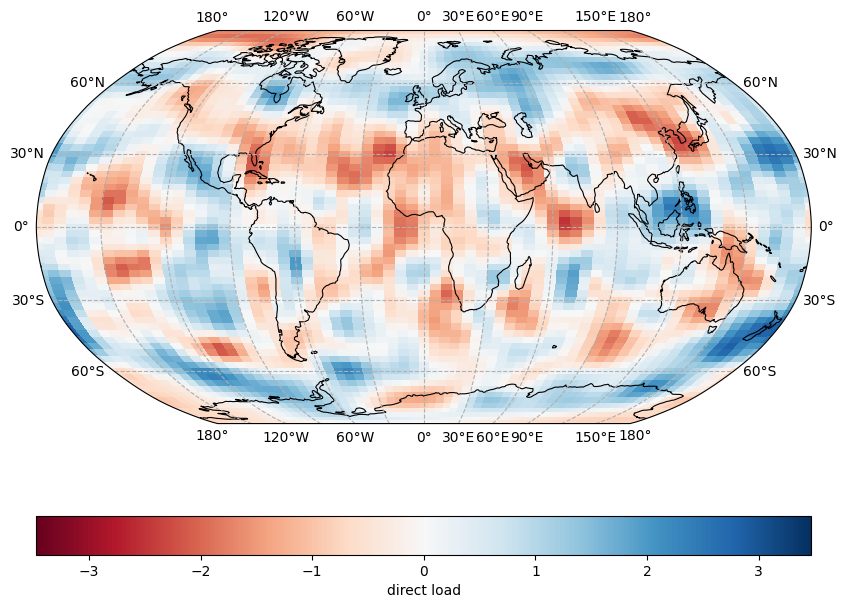

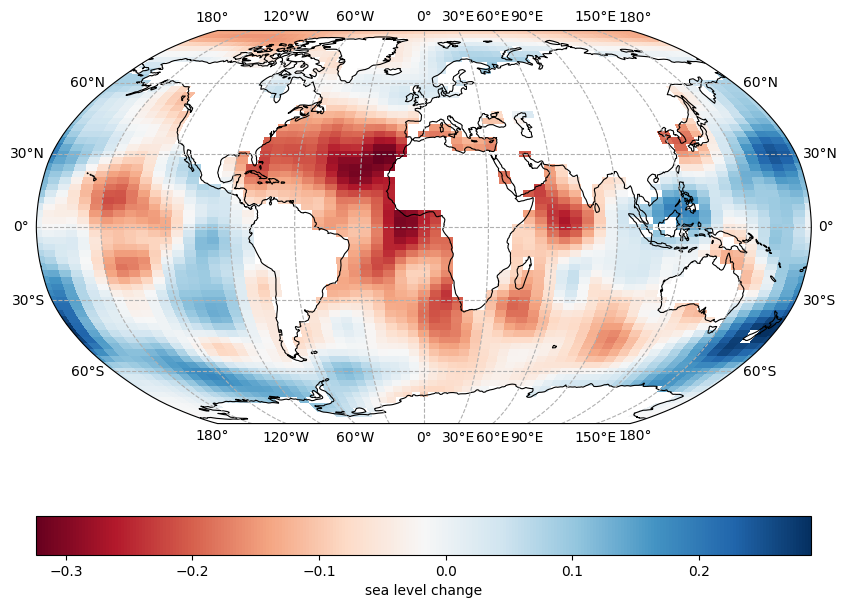

In [ ]:
# Set up the inversion
inversion = inf.LinearBayesianInversion(gfp, model_prior_measure)

# Generate synthetic data.
model, data = gfp.synthetic_model_and_data(model_prior_measure)
sea_level_change = gfp.sea_level_operator(model)[0]

# Plot the direct load input.
fig, ax, im = fingerprint.plot(model, symmetric=True)
model_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="direct load")

# Plot the resulting sea level
fig, ax, im = fingerprint.plot(sea_level_change, ocean_projection=True)
sea_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="sea level change")

# Invert the data.
pi = inversion.model_posterior_measure(data, inf.CGMatrixSolver())
inverted_model = pi.expectation
inverted_sea_level_change = gfp.sea_level_operator(inverted_model)[0]

# Plot the inverted direct load input.
fig, ax, im = fingerprint.plot(inverted_model, ice_projection=True)
im.set_clim(model_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted direct load")

# Plot the resulting sea level
fig, ax, im = fingerprint.plot(inverted_sea_level_change, ocean_projection=True)
im.set_clim(sea_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted sea level change")

print(f"global mean sea level change = {fingerprint.ocean_average(sea_level_change)}")
print(
    f"estimated global mean sea level change = {fingerprint.ocean_average(inverted_sea_level_change)}"
)
